## Introduction

## Imports

In [1]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

#Increases the resolution of the graphs rendered below
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

 
## 1. Find all variables and understand them

In [2]:
#Importing the dataset
dataPath = "raw_data"
df = pd.read_csv(dataPath + "/market_segmentation.csv")
#Displaying the first 10 instances of the dataset
df[0:10]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [3]:
#Find the number of rows and columns in the dataset
print(df.shape)
#Find the different data types in the dataset
df.dtypes

(8068, 11)


ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [4]:
# Summary statistics of the data
# For things like outliers or any weird stuff
print("Summary Statistics of Numerical Variables\n", 
      df.select_dtypes(include = "number").describe(),
     "\n")

print("Summary Statistics of Categorical Variables\n",
      df.select_dtypes(include = "object").describe(),
     "\n")


Summary Statistics of Numerical Variables
                   ID          Age  Work_Experience  Family_Size
count    8068.000000  8068.000000      7239.000000  7733.000000
mean   463479.214551    43.466906         2.641663     2.850123
std      2595.381232    16.711696         3.406763     1.531413
min    458982.000000    18.000000         0.000000     1.000000
25%    461240.750000    30.000000         0.000000     2.000000
50%    463472.500000    40.000000         1.000000     3.000000
75%    465744.250000    53.000000         4.000000     4.000000
max    467974.000000    89.000000        14.000000     9.000000 

Summary Statistics of Categorical Variables
        Gender Ever_Married Graduated Profession Spending_Score  Var_1  \
count    8068         7928      7990       7944           8068   7992   
unique      2            2         2          9              3      7   
top      Male          Yes       Yes     Artist            Low  Cat_6   
freq     4417         4643      4968      

A quick look at the metrics we can see that work experience may be right skewed as the mean and median does not match. Additionally, outliers may be present as the max value of work experience is order of magnitude highter than other metrics.



In [5]:
print("Summary Statistics of Missing Values \n", 
      df.isnull().sum(axis=0),
     "\n")

Summary Statistics of Missing Values 
 ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64 



Seems like work experience and family size have a lot of missing values.

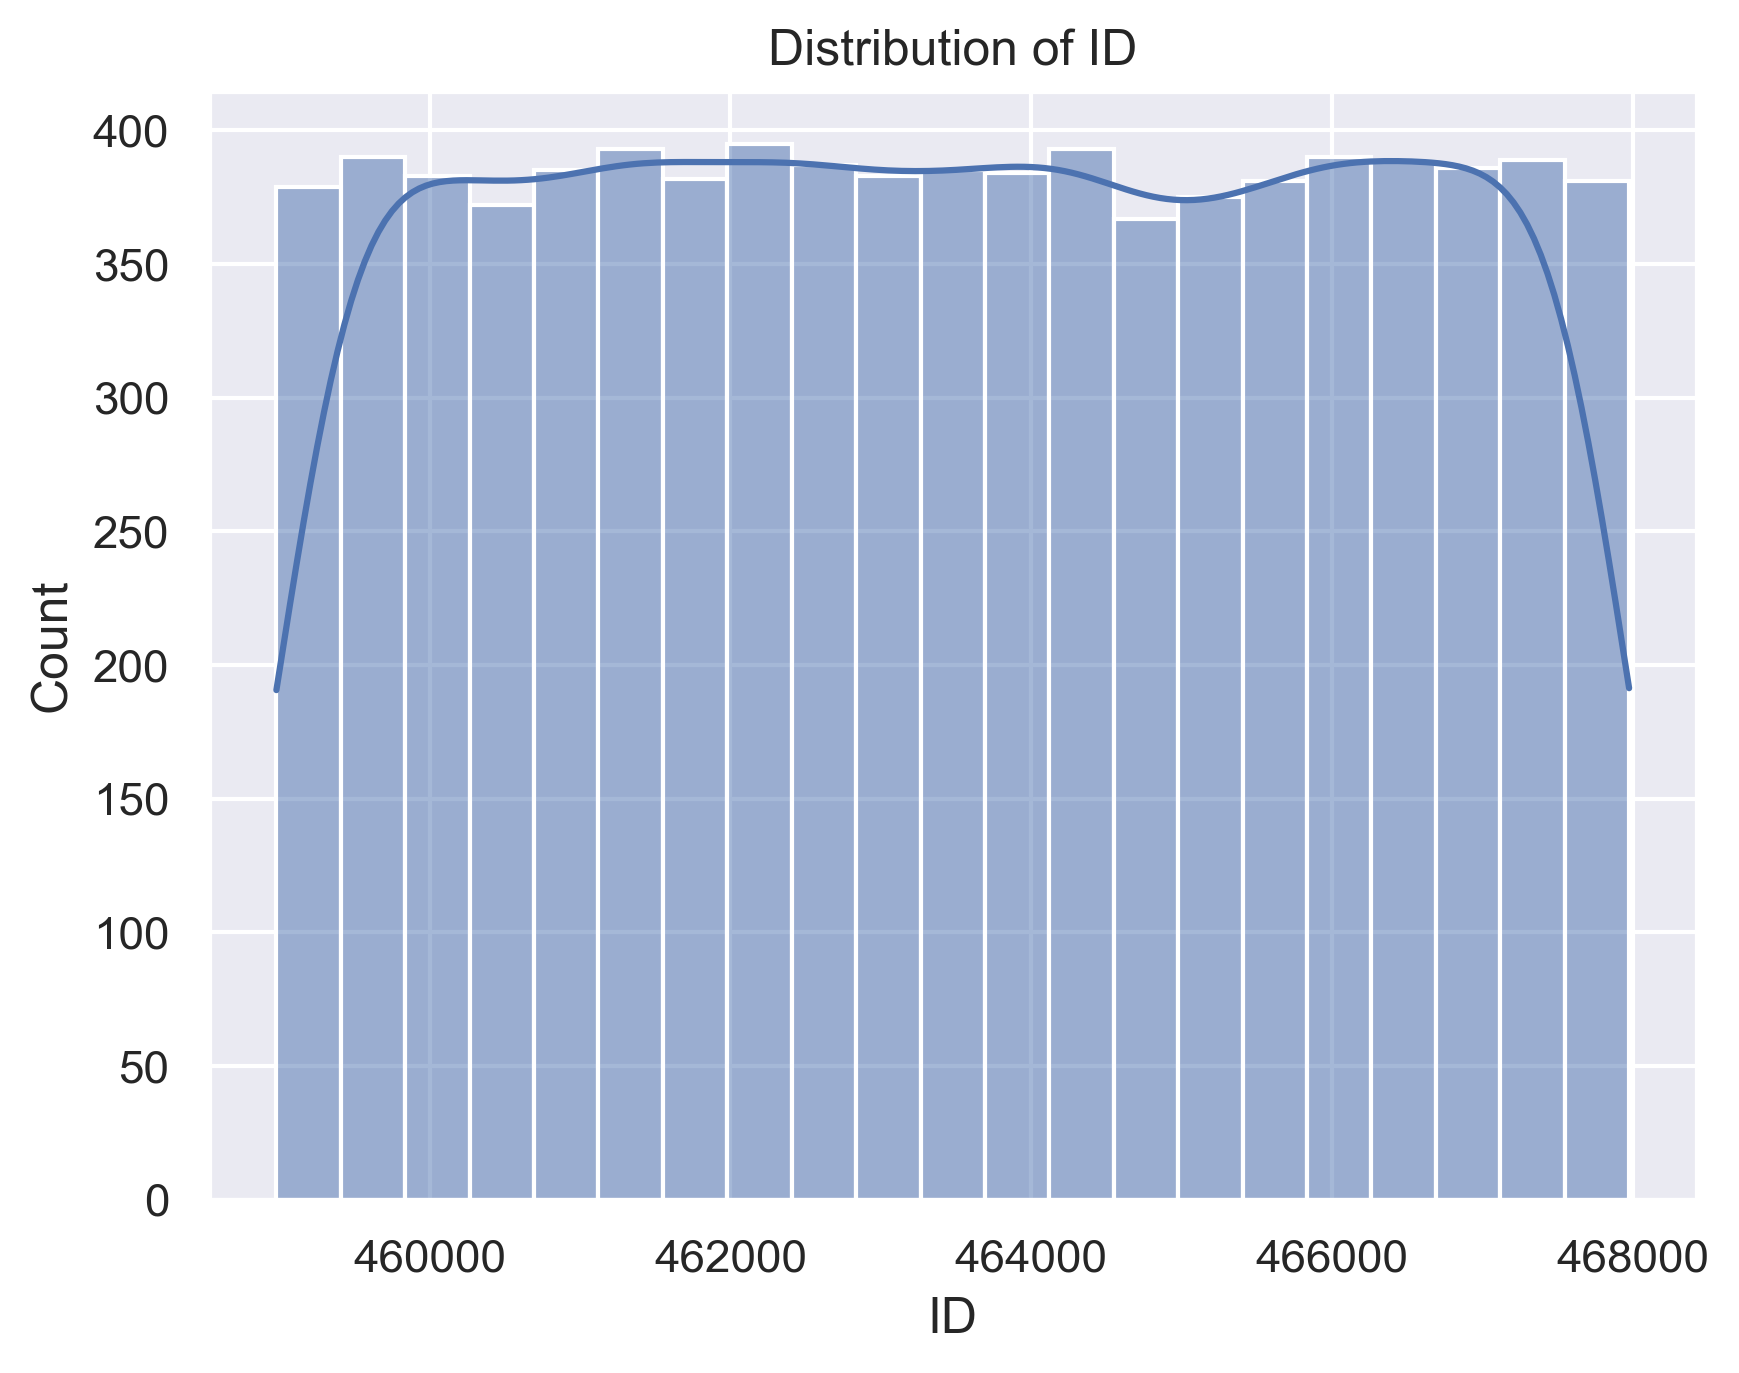

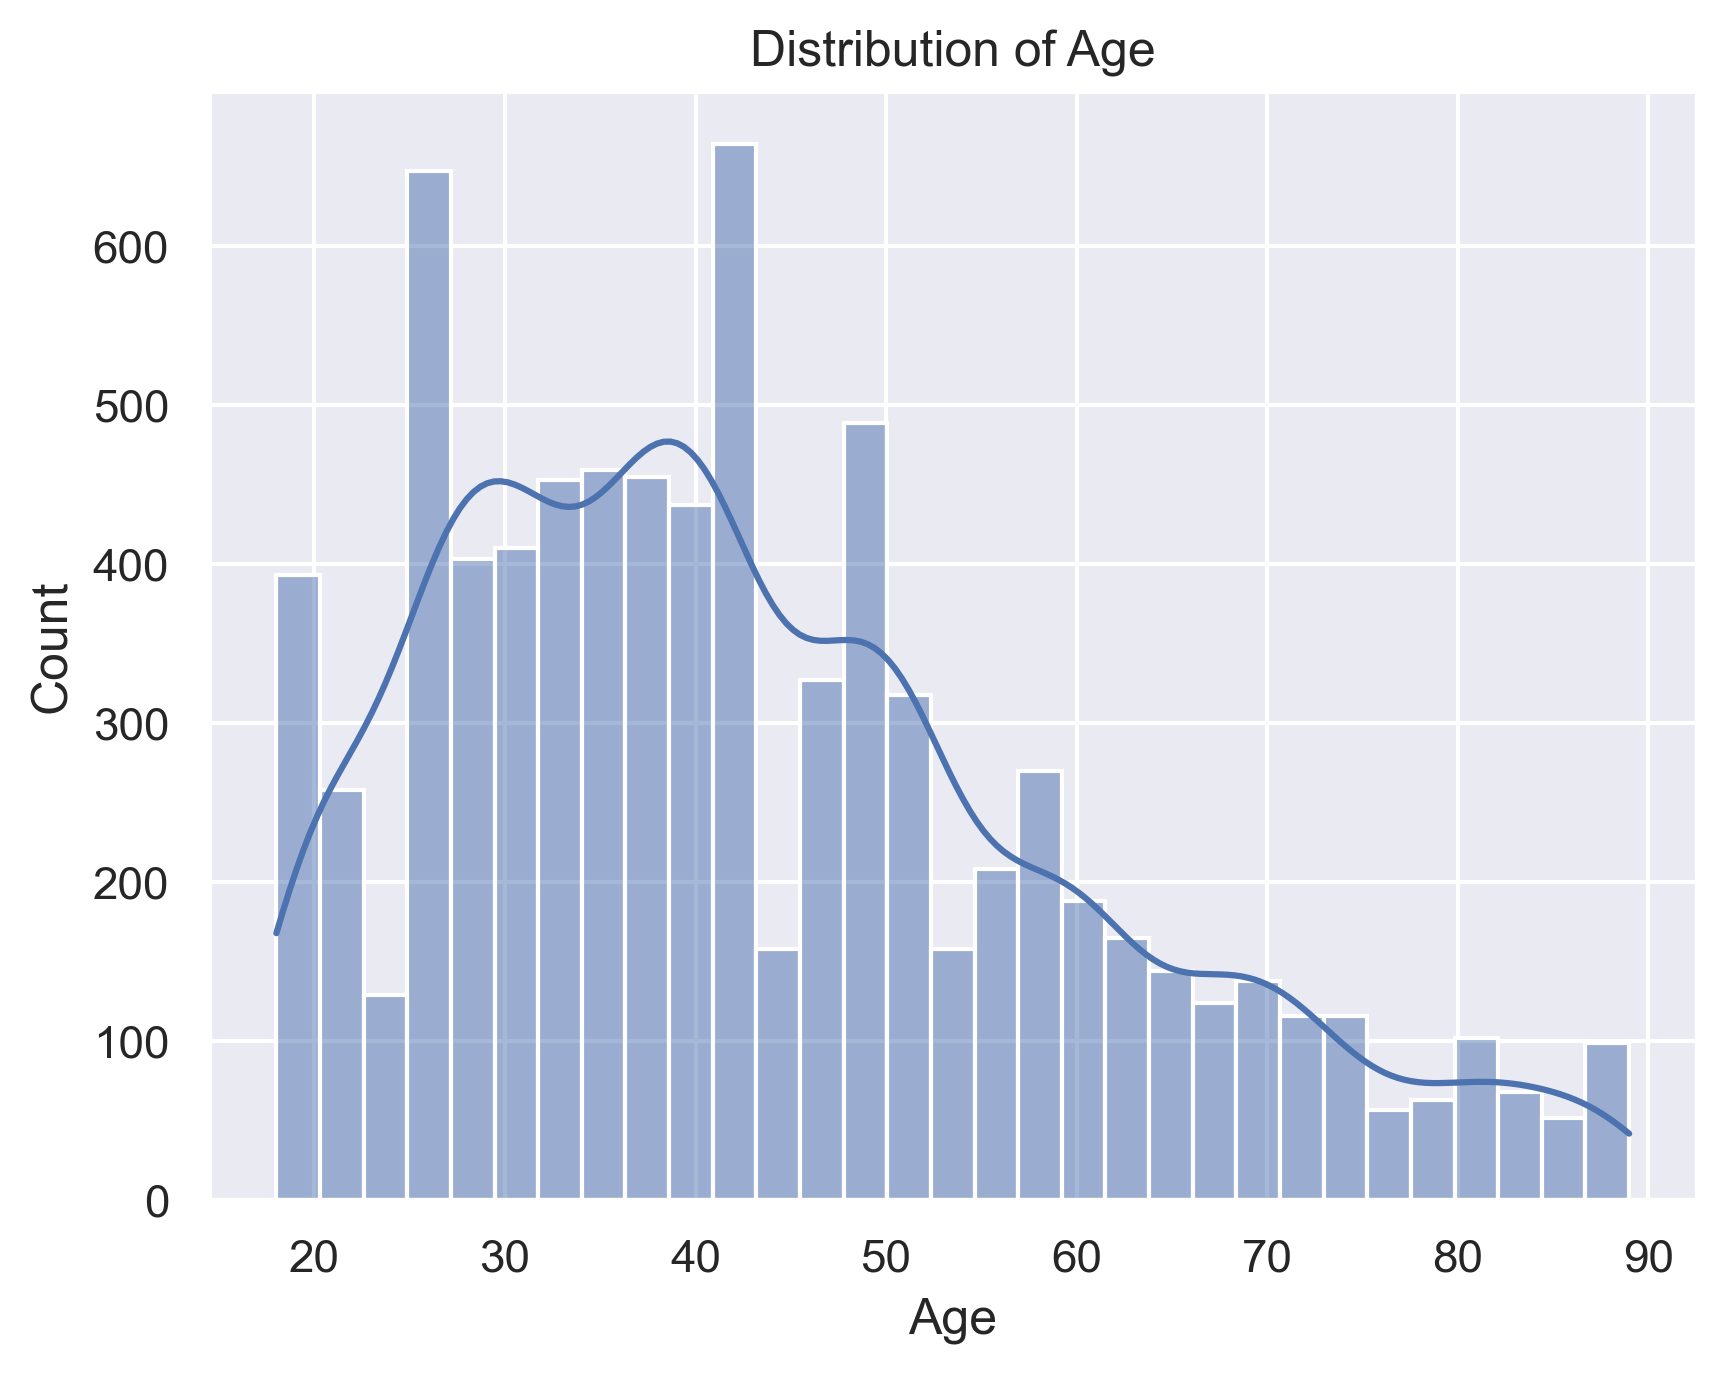

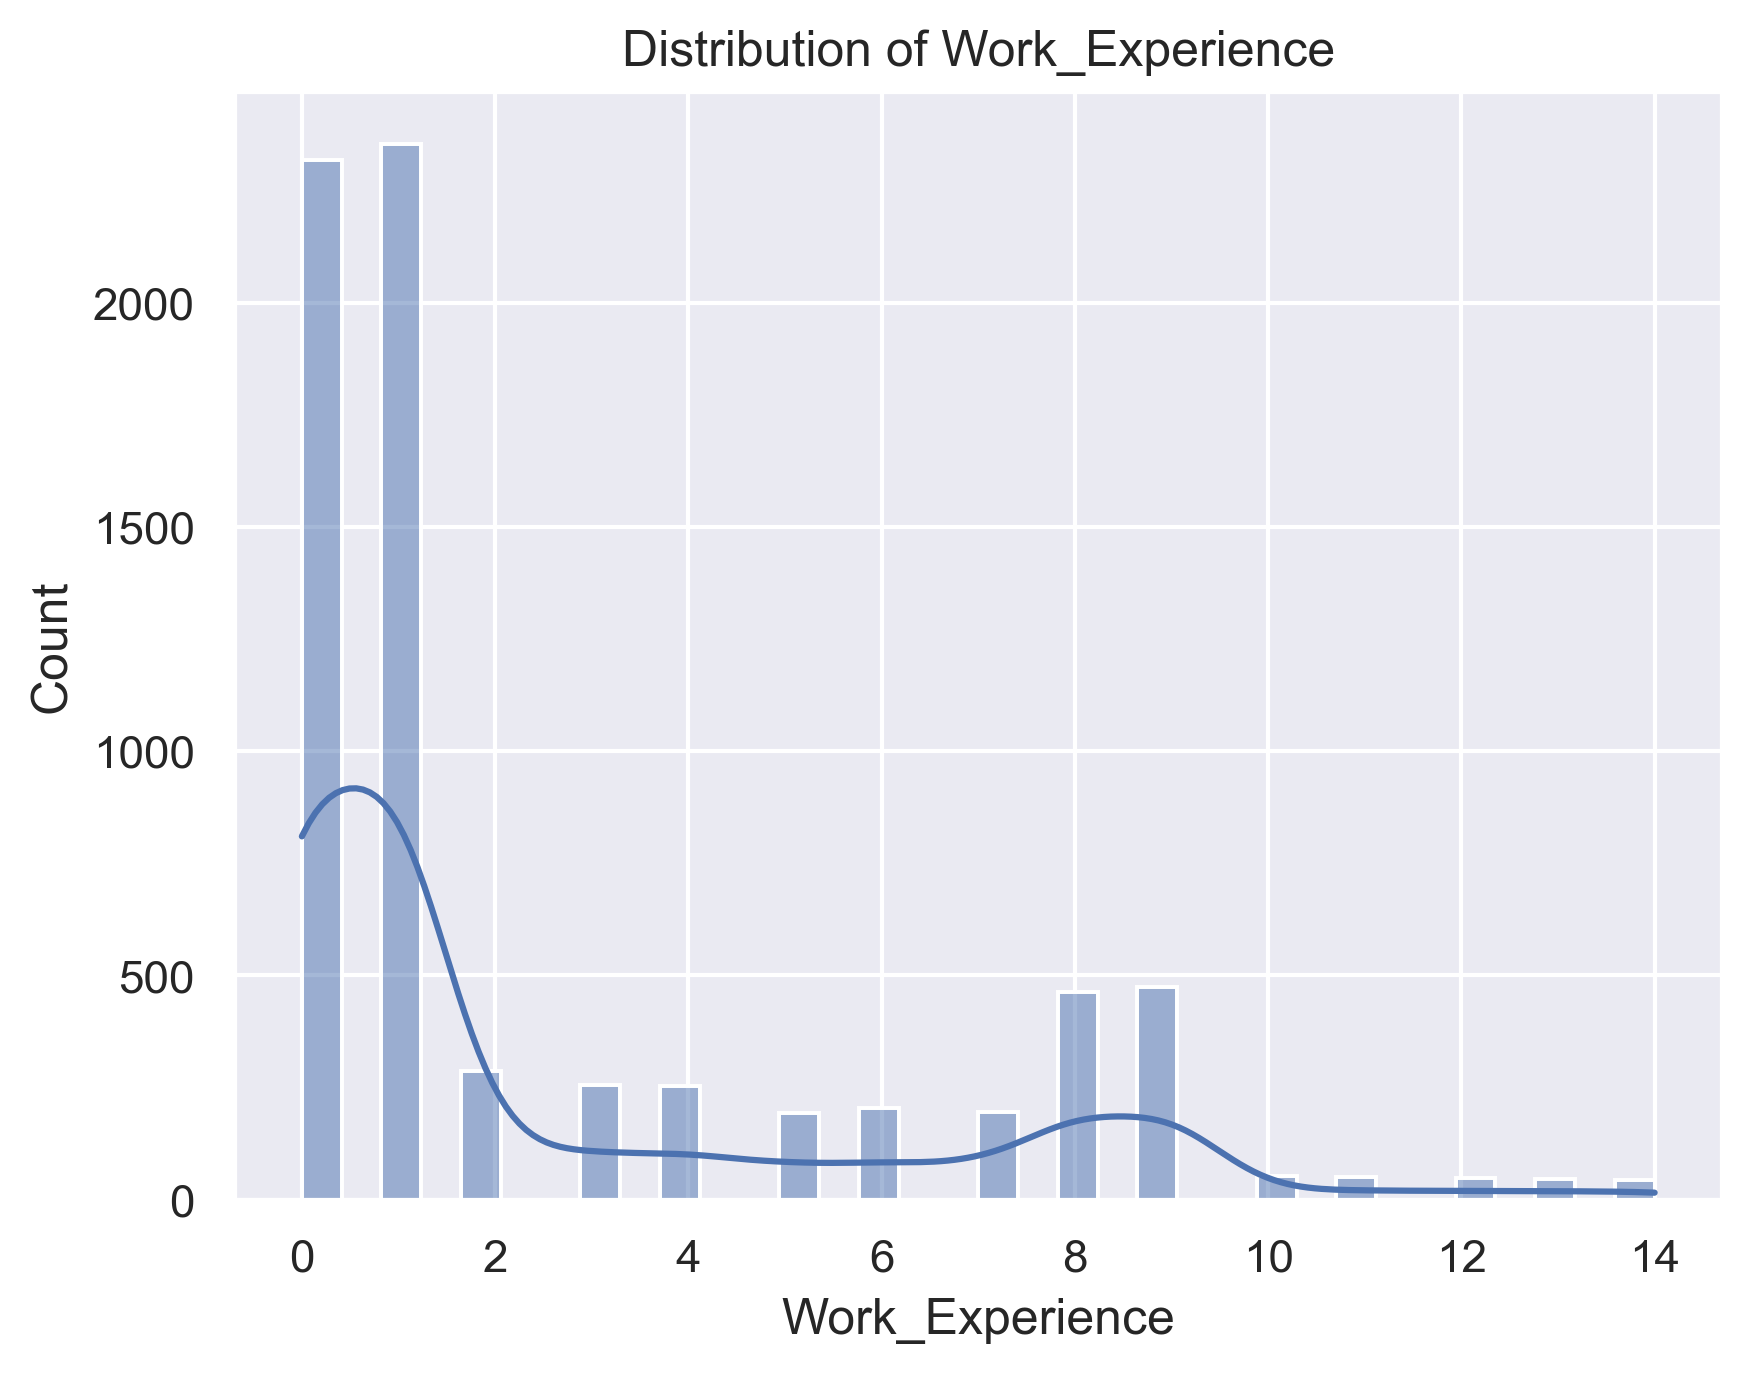

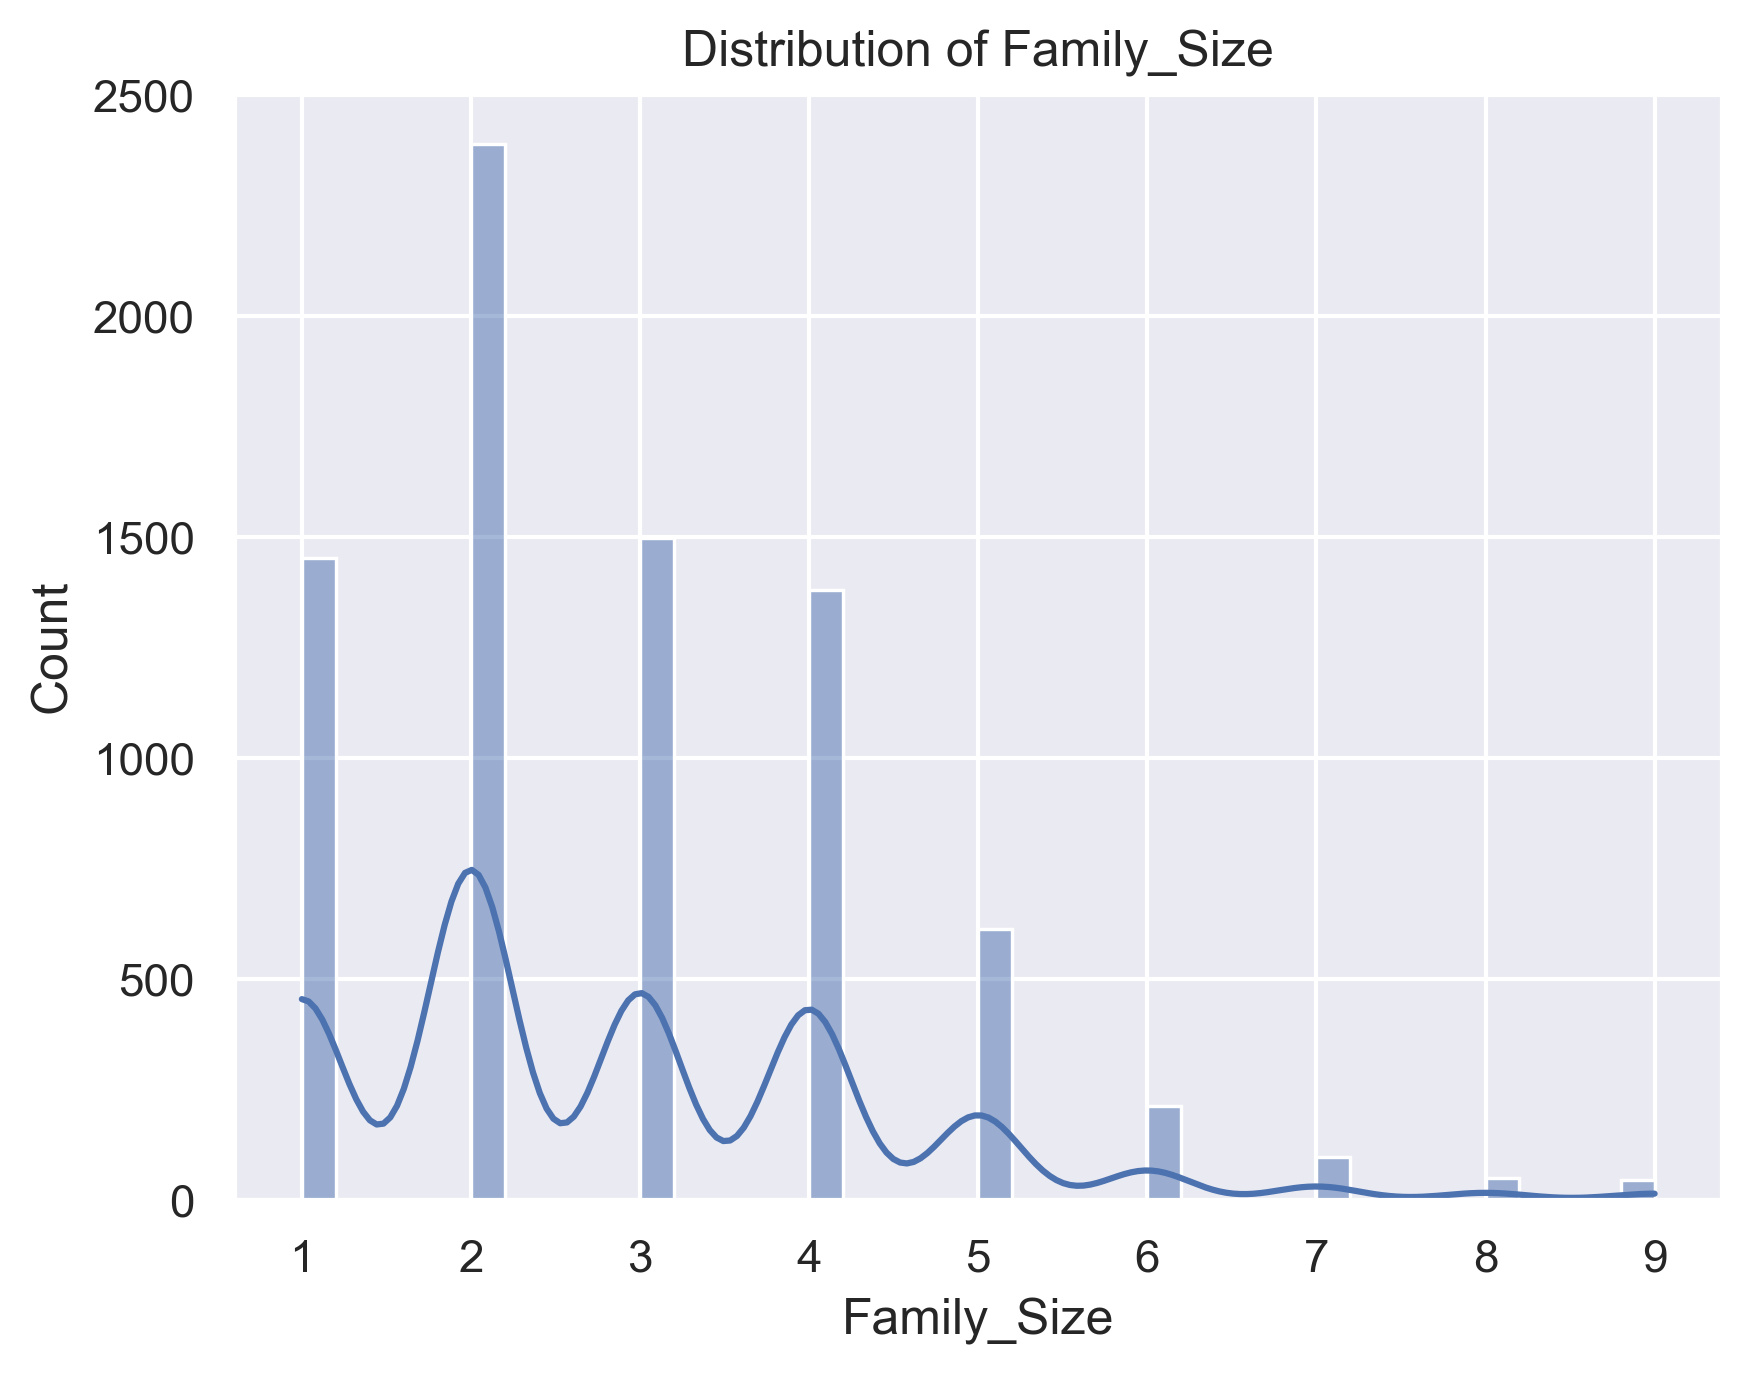

In [6]:
# This looks at the distribution of all numberical data 
for i, v in enumerate(df.select_dtypes(include = "number")):
    sns.histplot(df[v], kde = True)
    plt.title("Distribution of " + v)
    plt.show()

We can see that family size, work experience and age are all somewhat right skewed; lets see if we can apply log to the variables and see whether it can make it more evenly distributed.

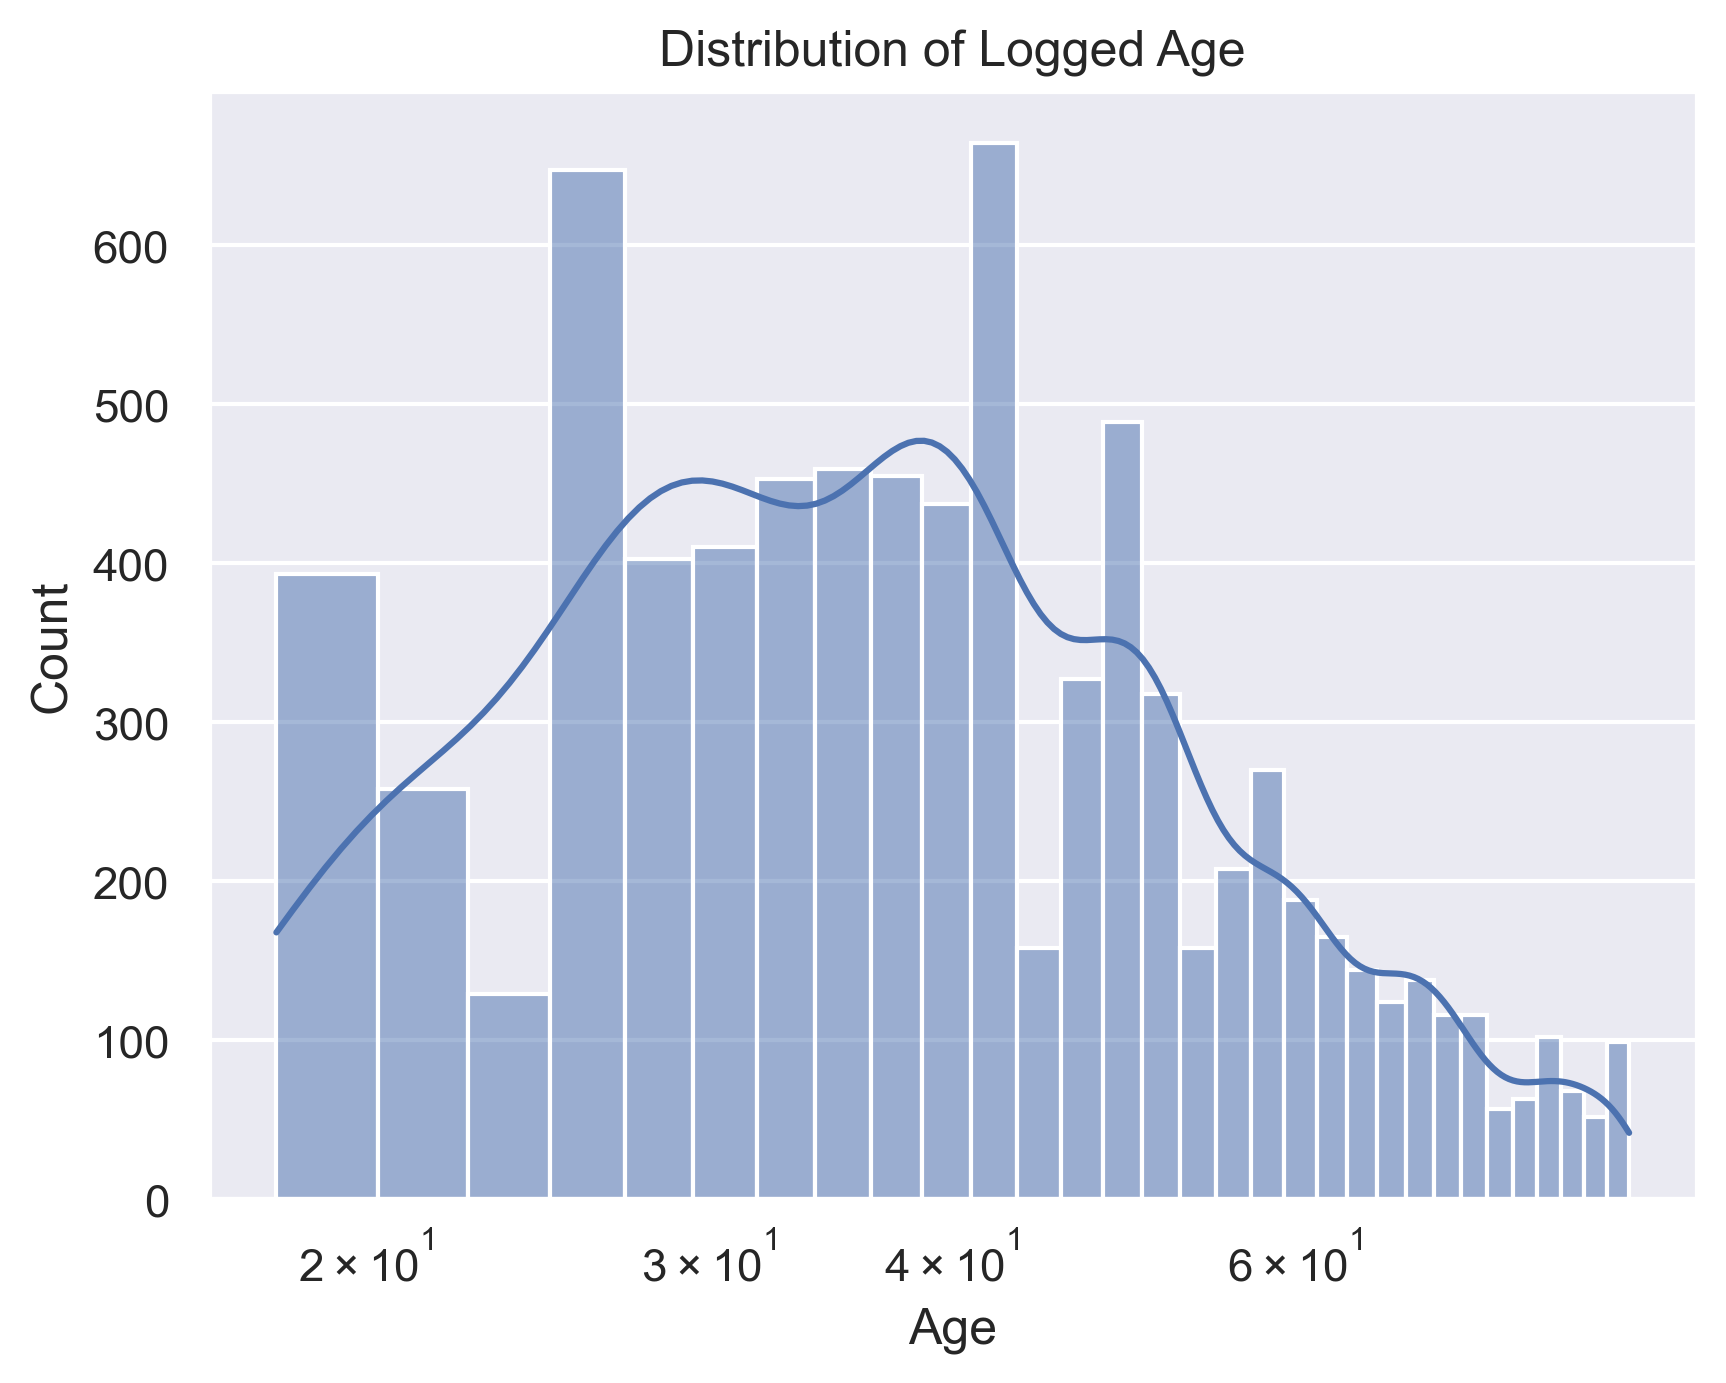

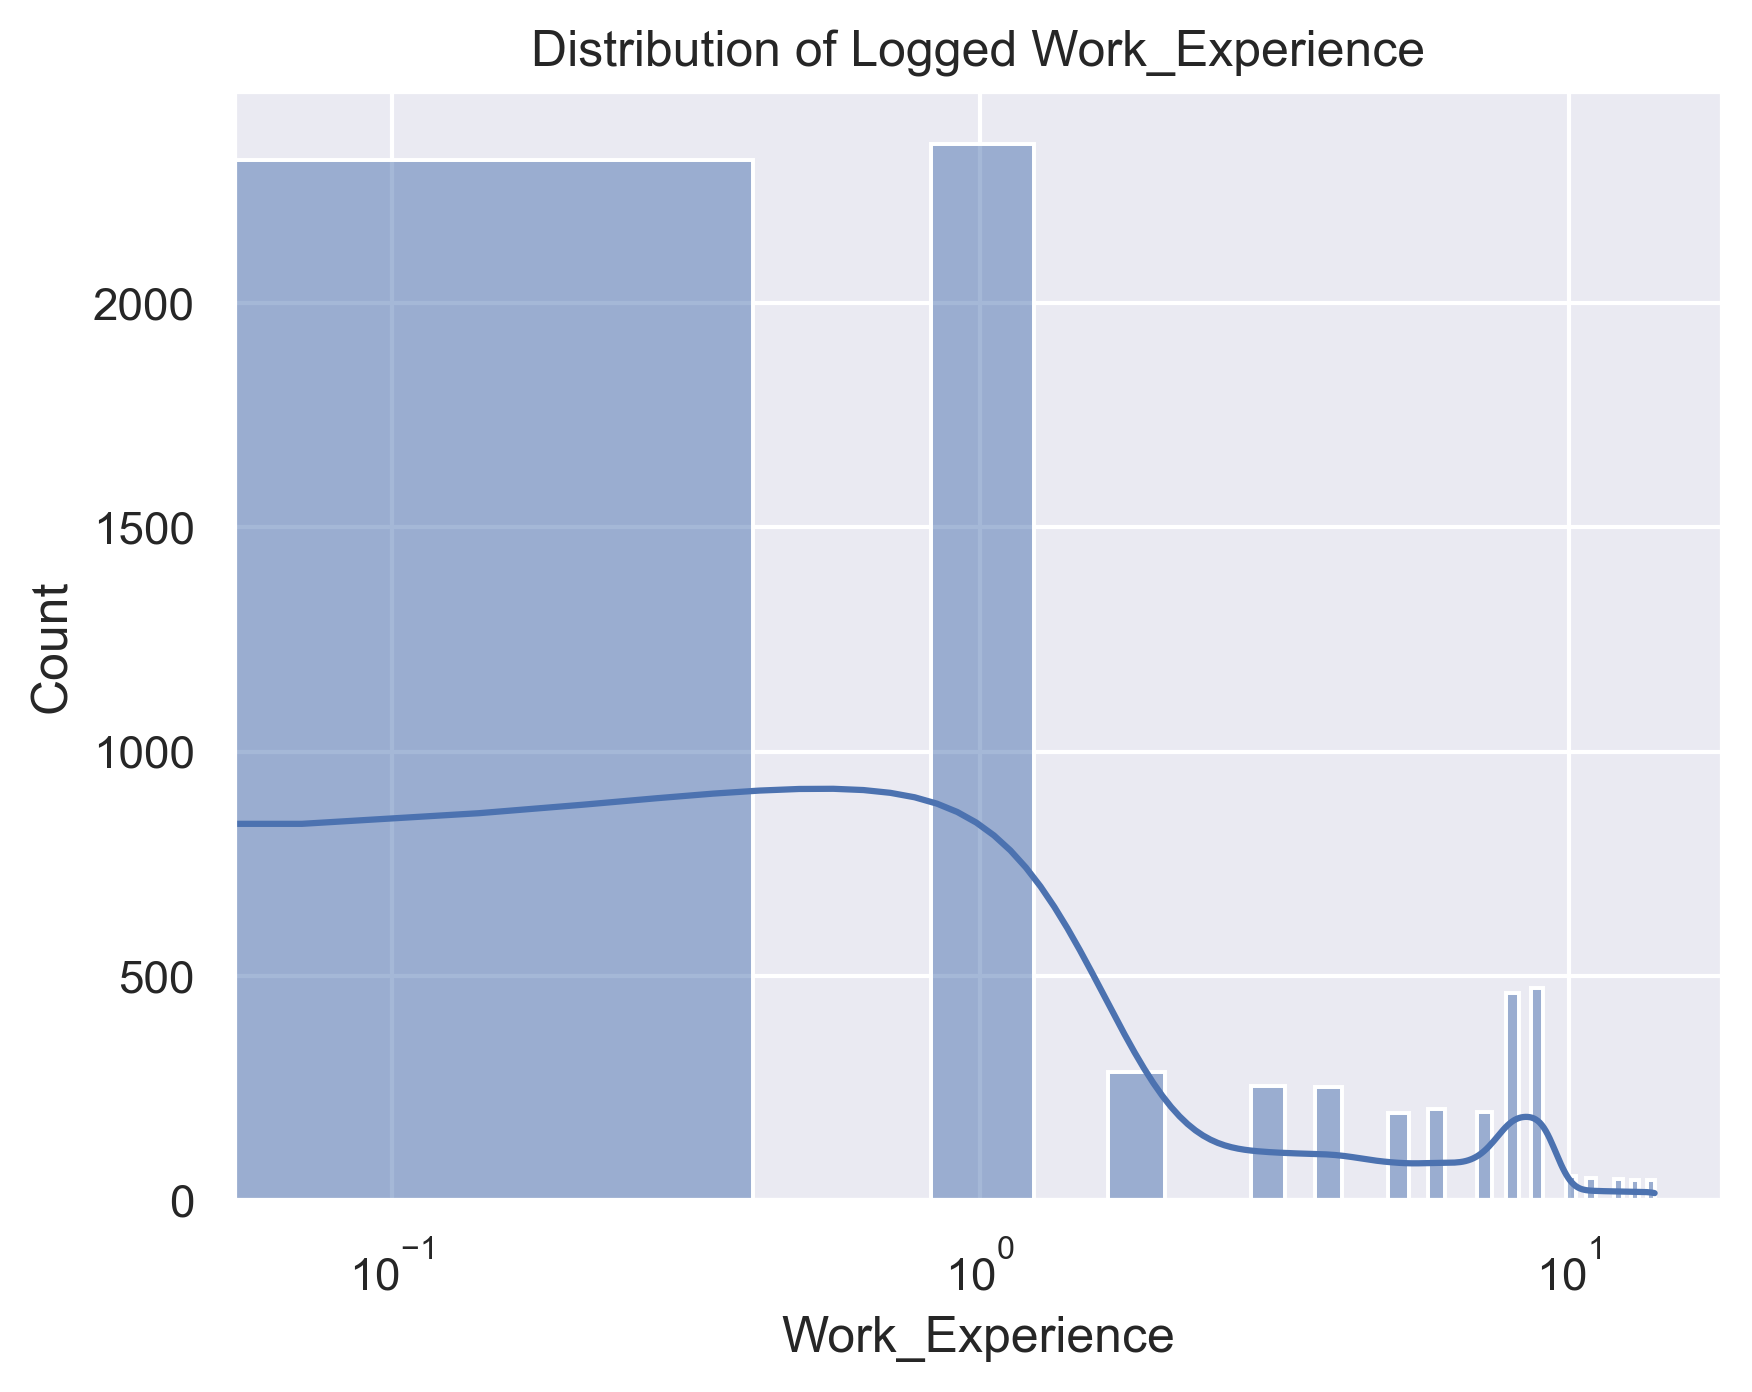

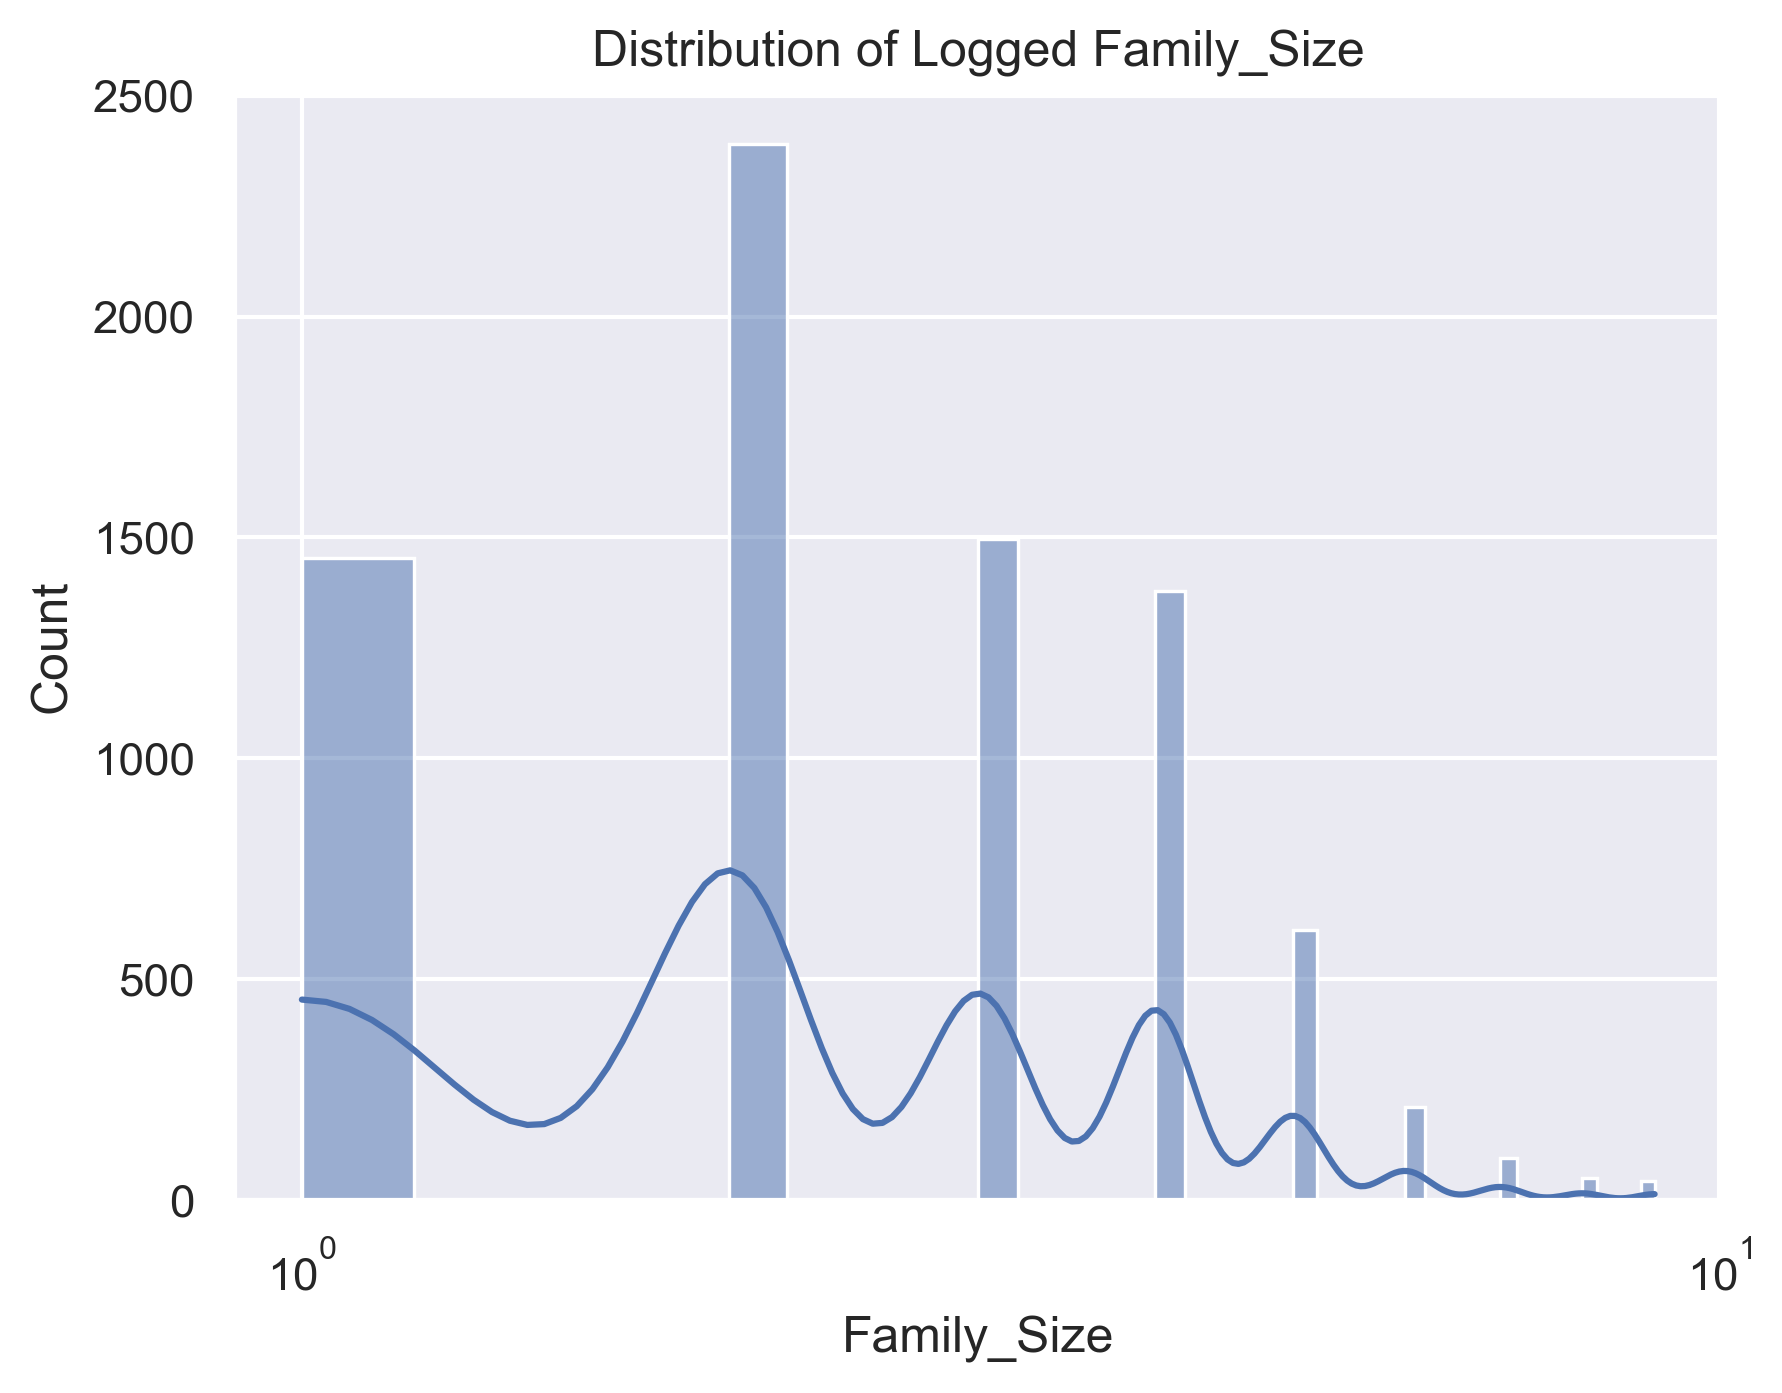

In [7]:
for i, v in enumerate(["Age", "Work_Experience", "Family_Size"]):
    sns.histplot(df[v], kde = True)
    plt.xscale("log")
    plt.title("Distribution of Logged " + v)
    plt.show()

After logging the relevant variables(ID wouldn't be useful for analysis) we can see that the distribution of Age and Family Size have both improved but not so much for work experience; we could look further into work experience distribution later. 

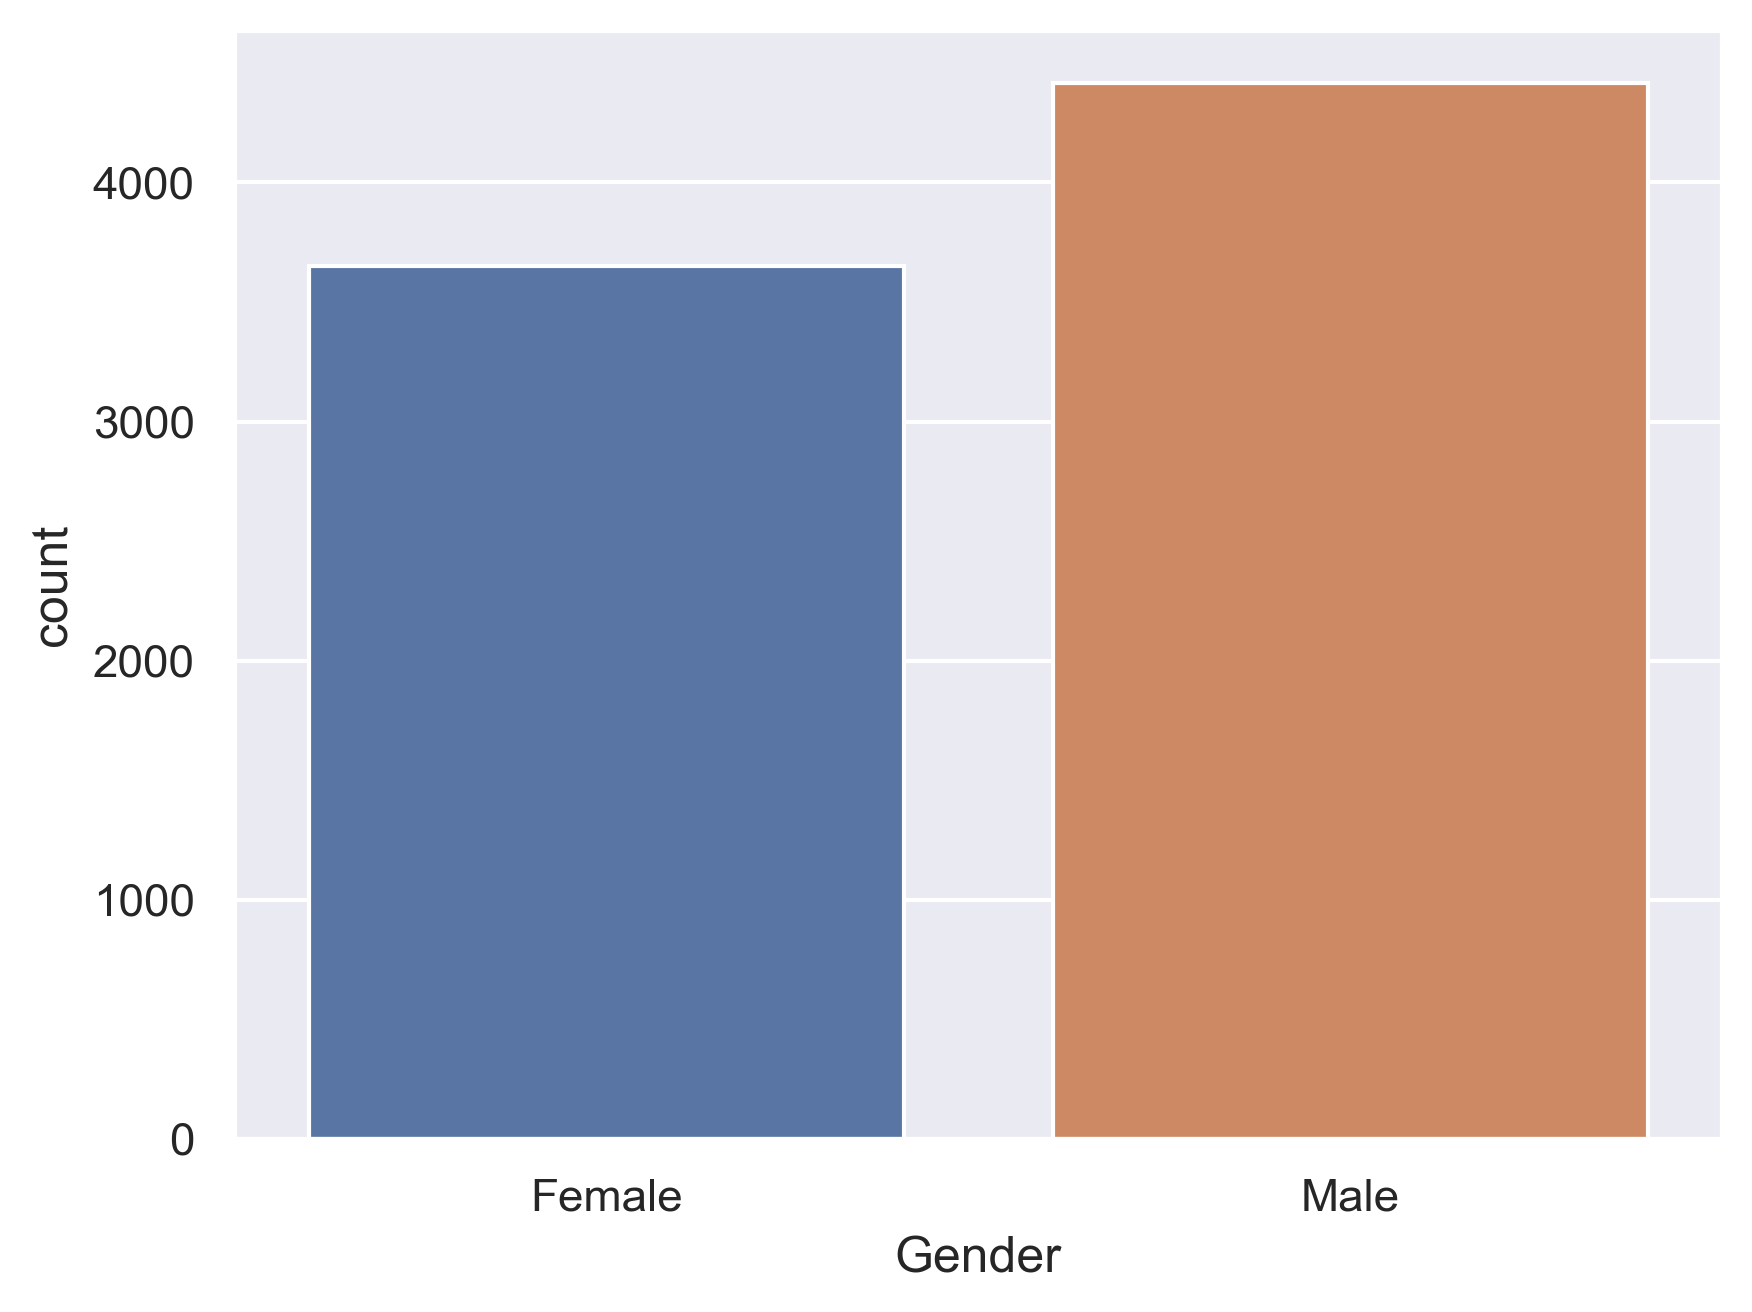

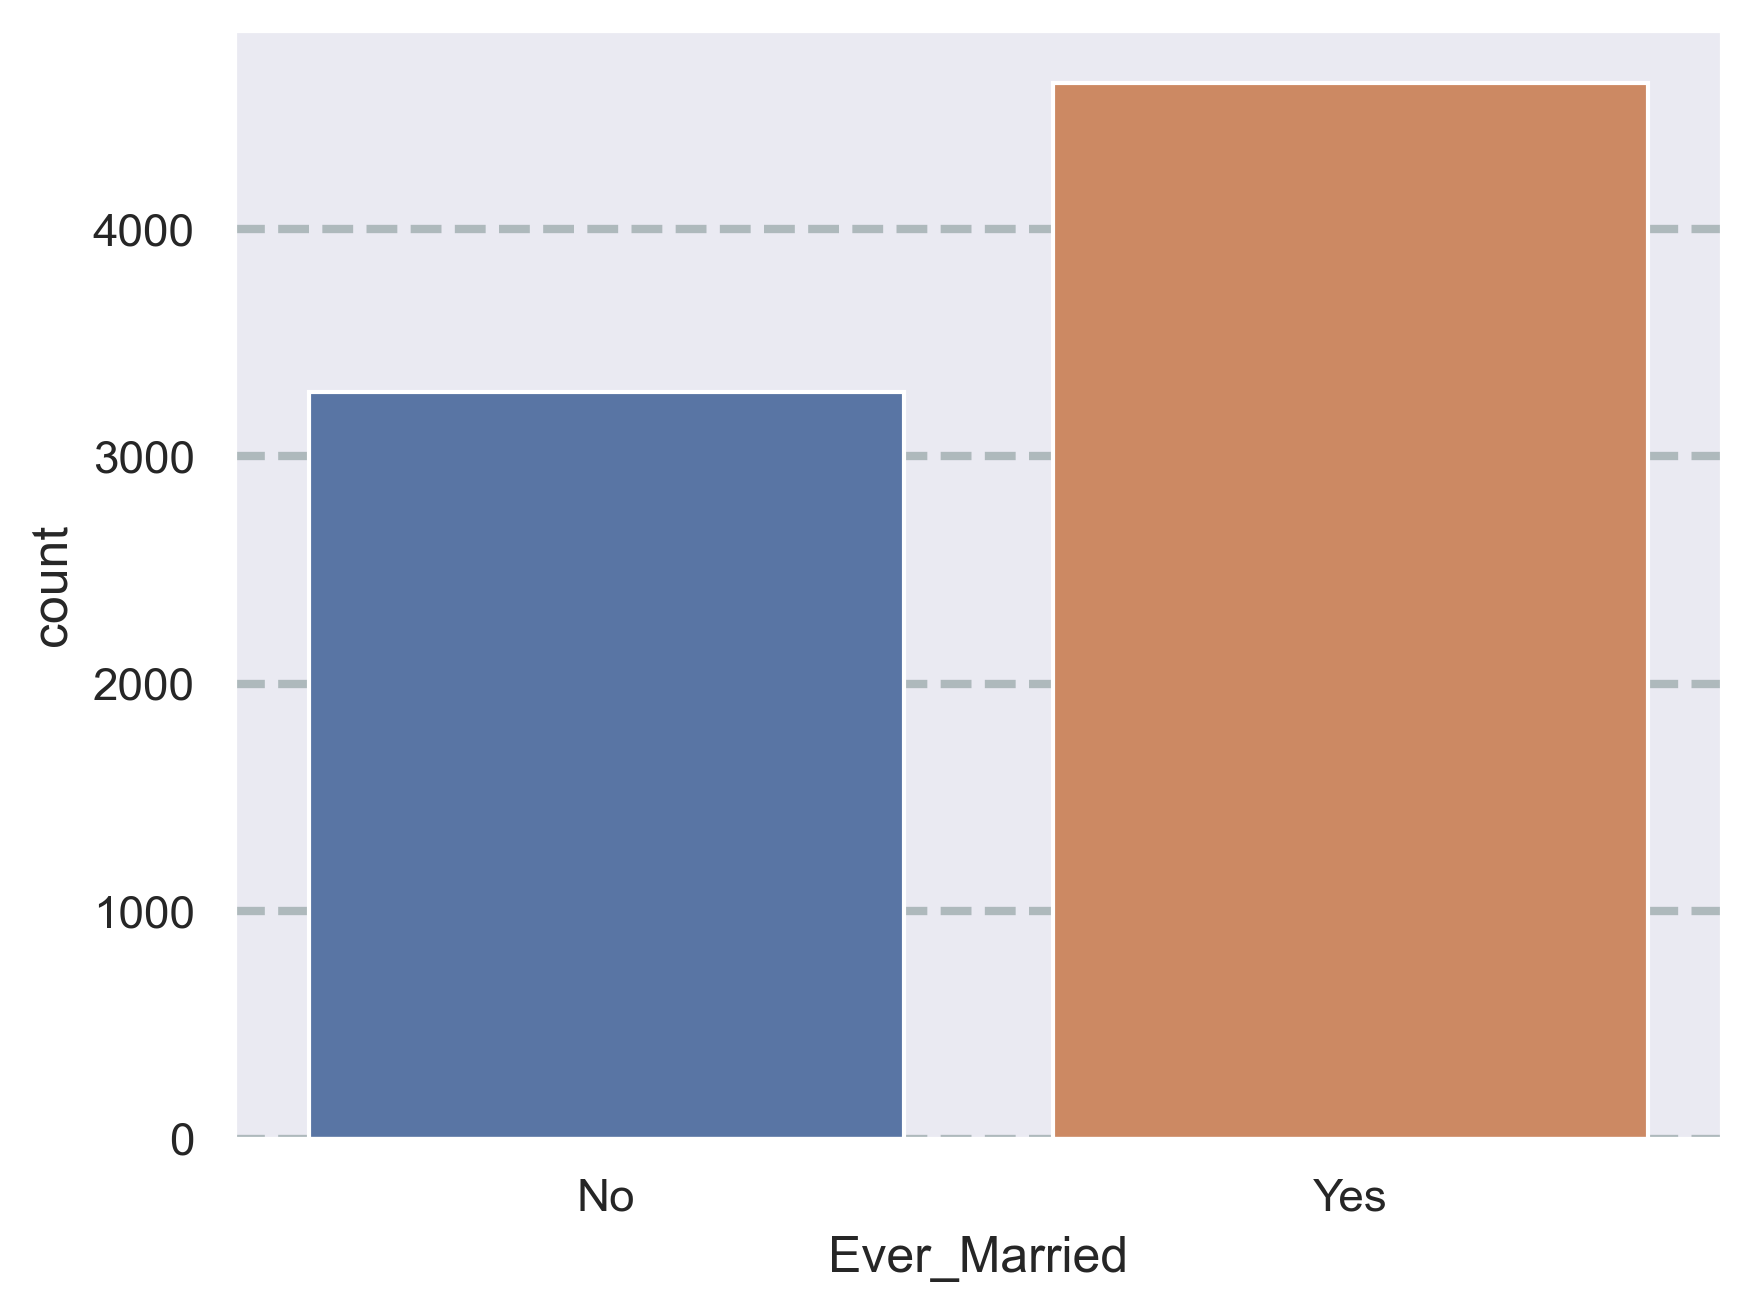

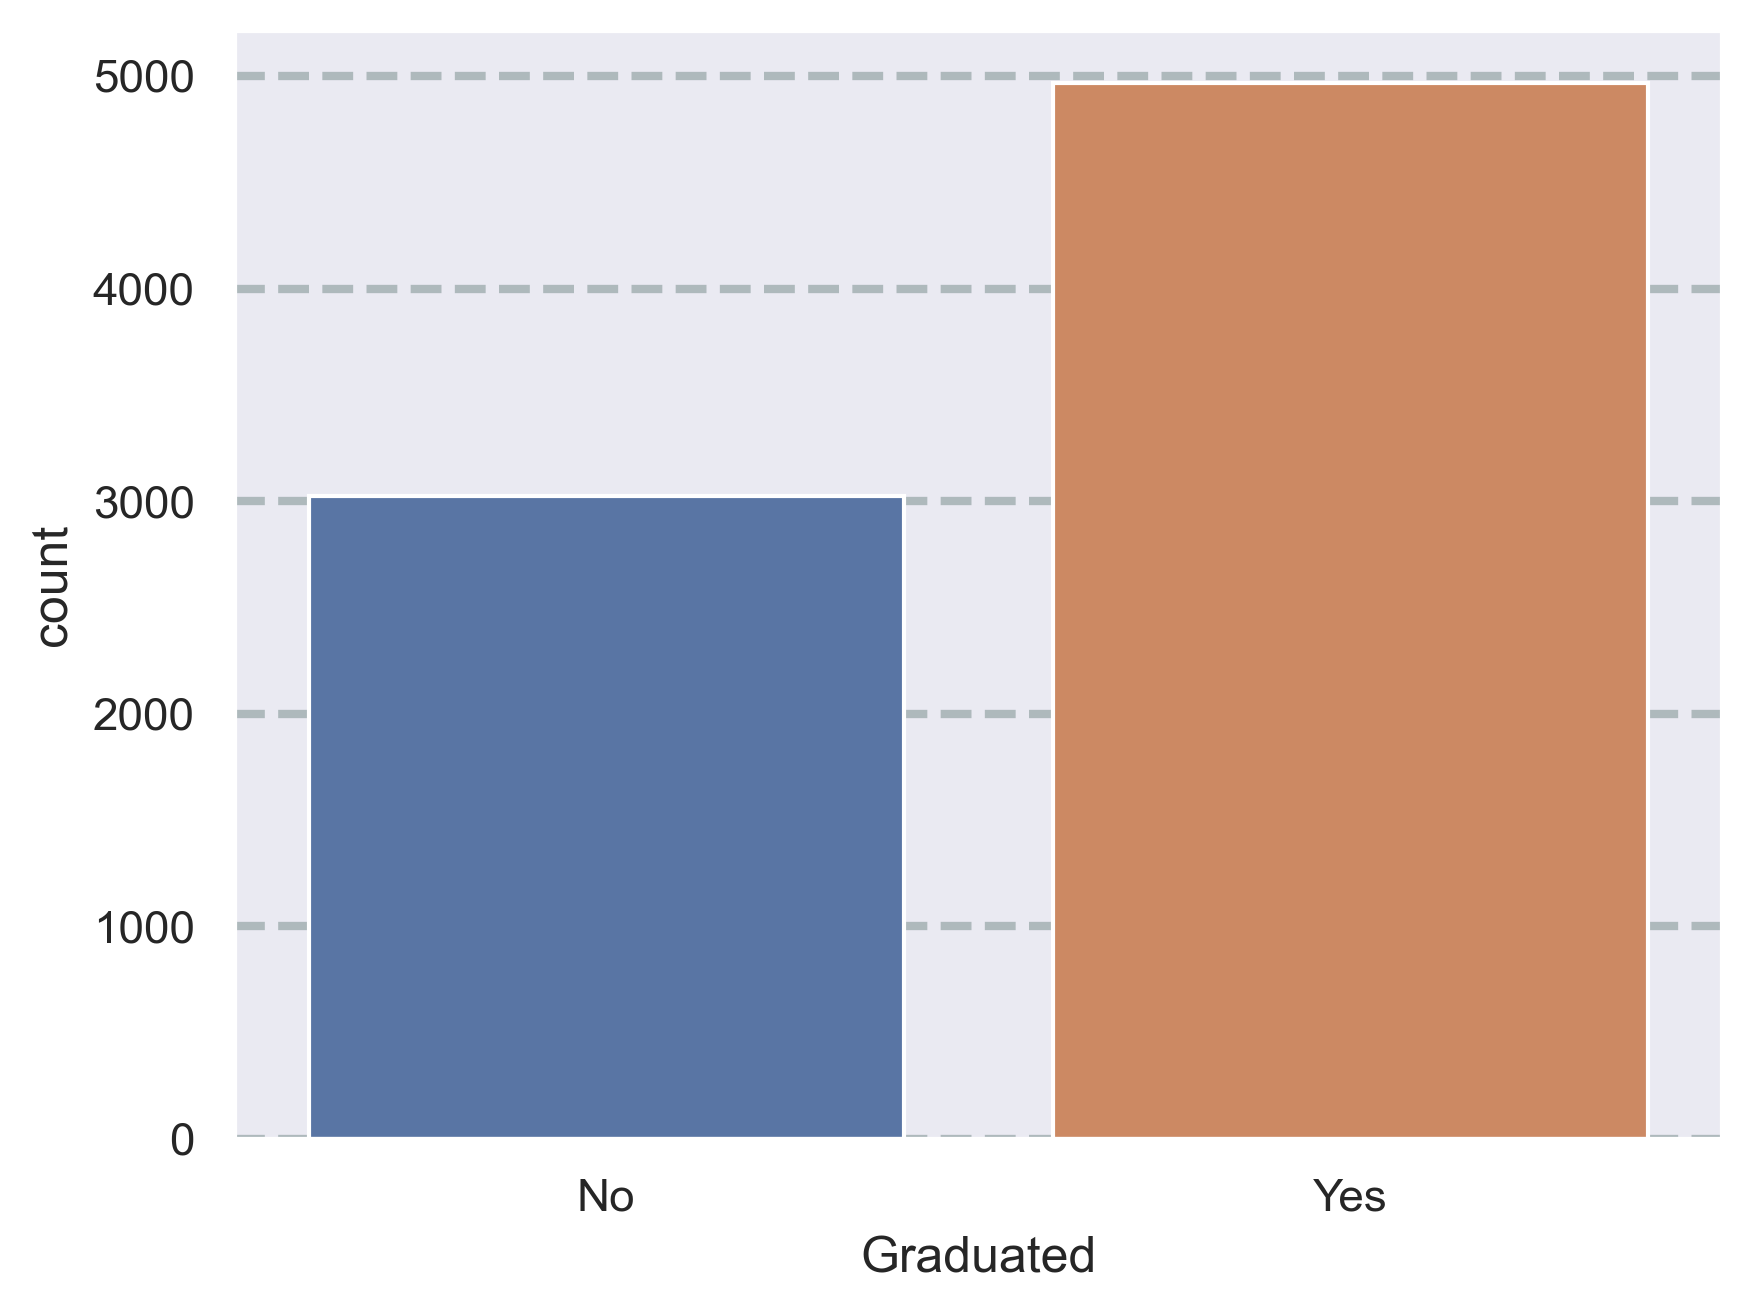

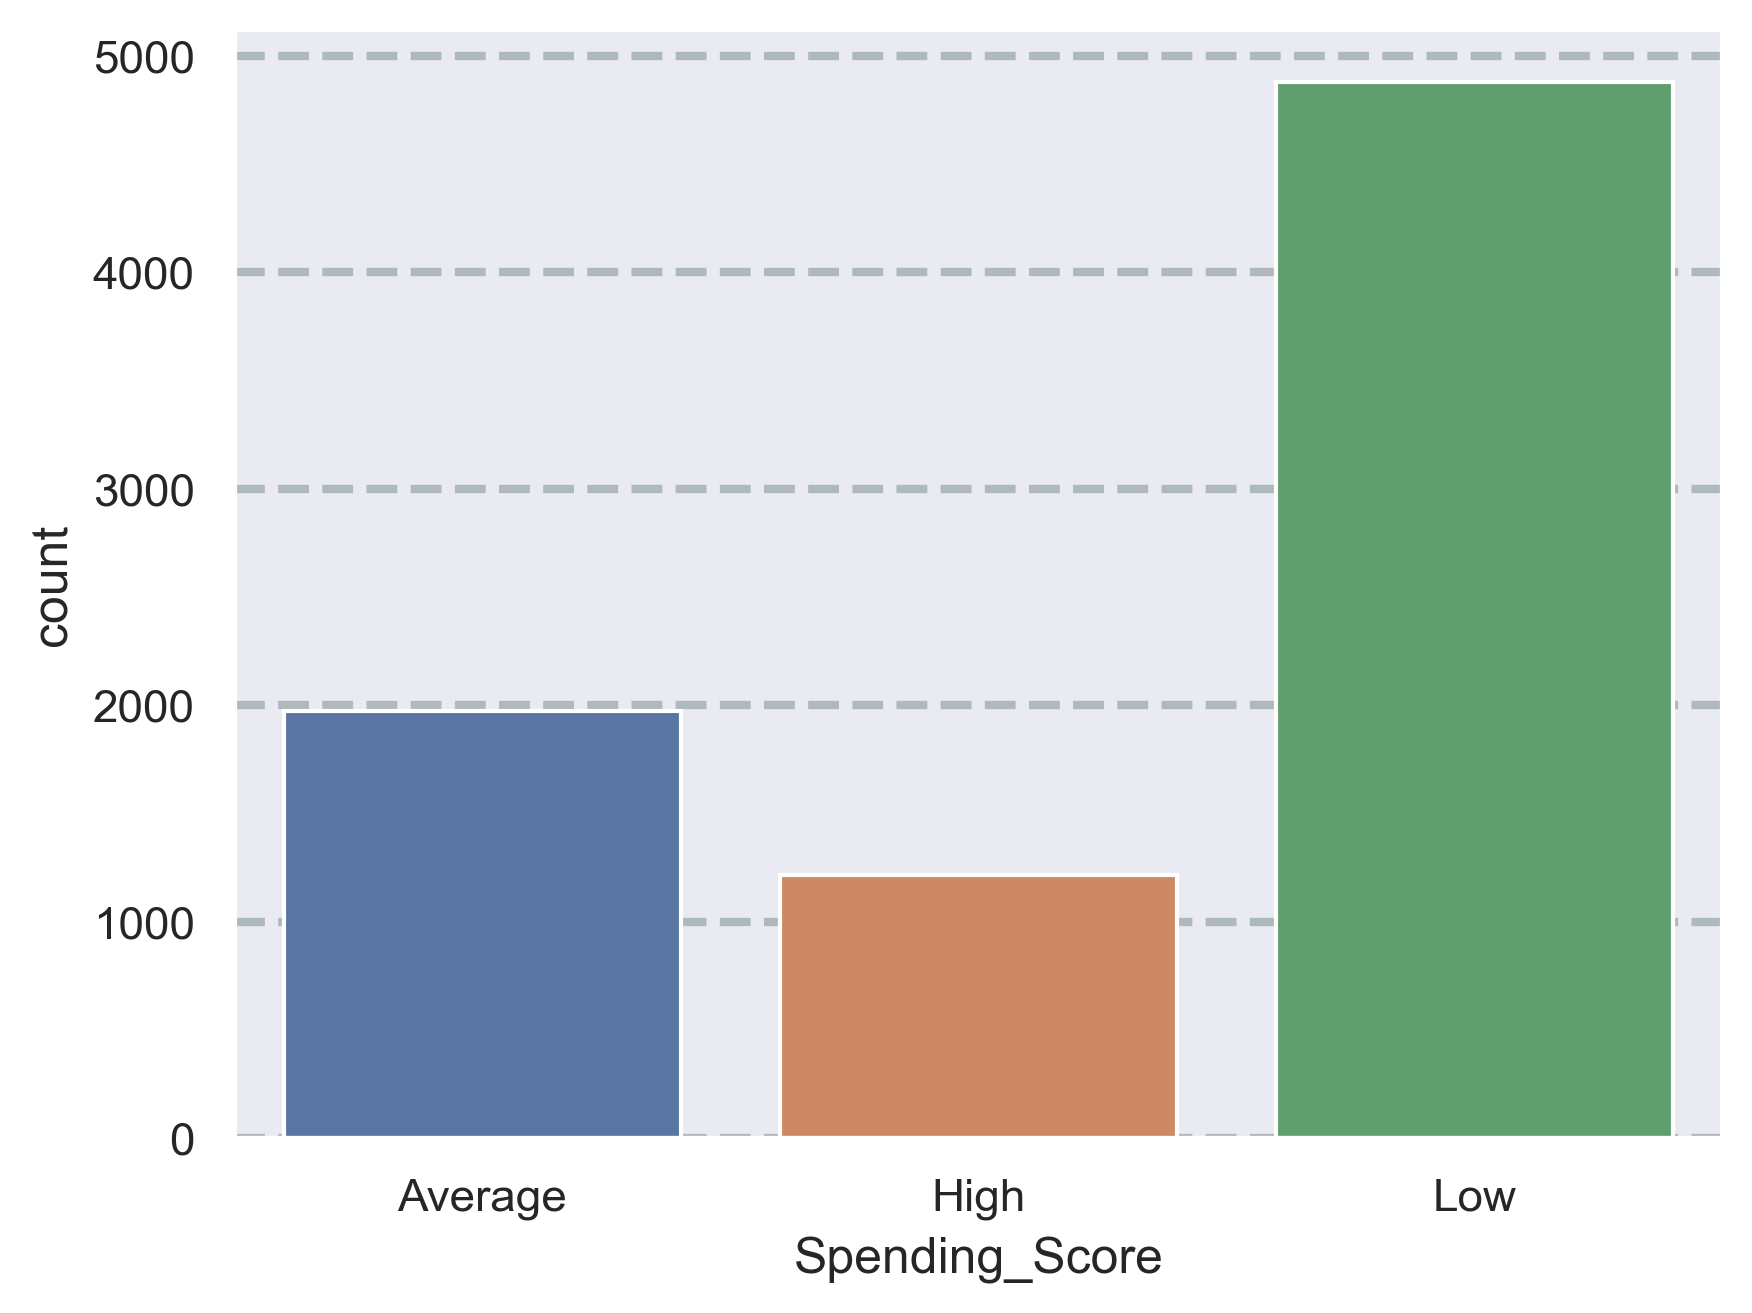

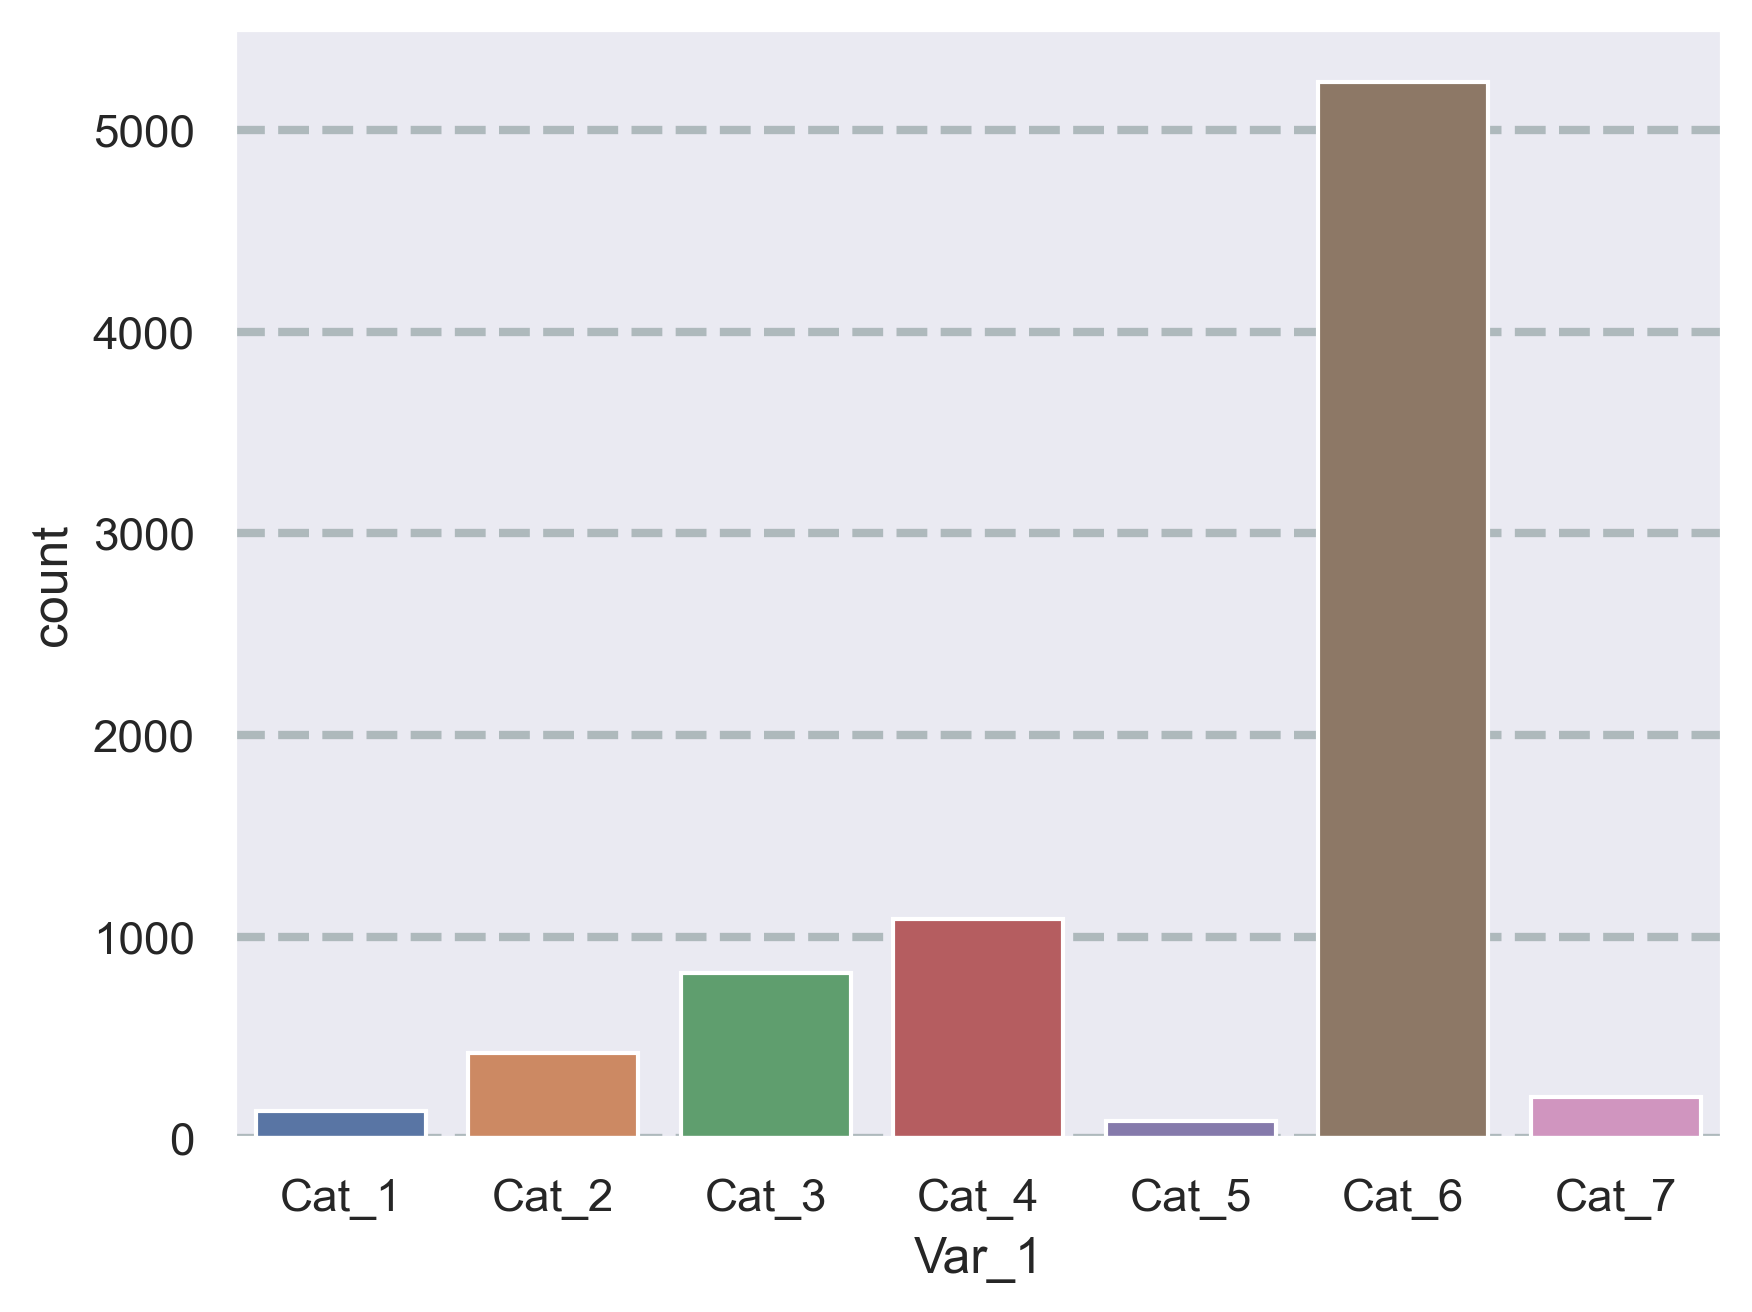

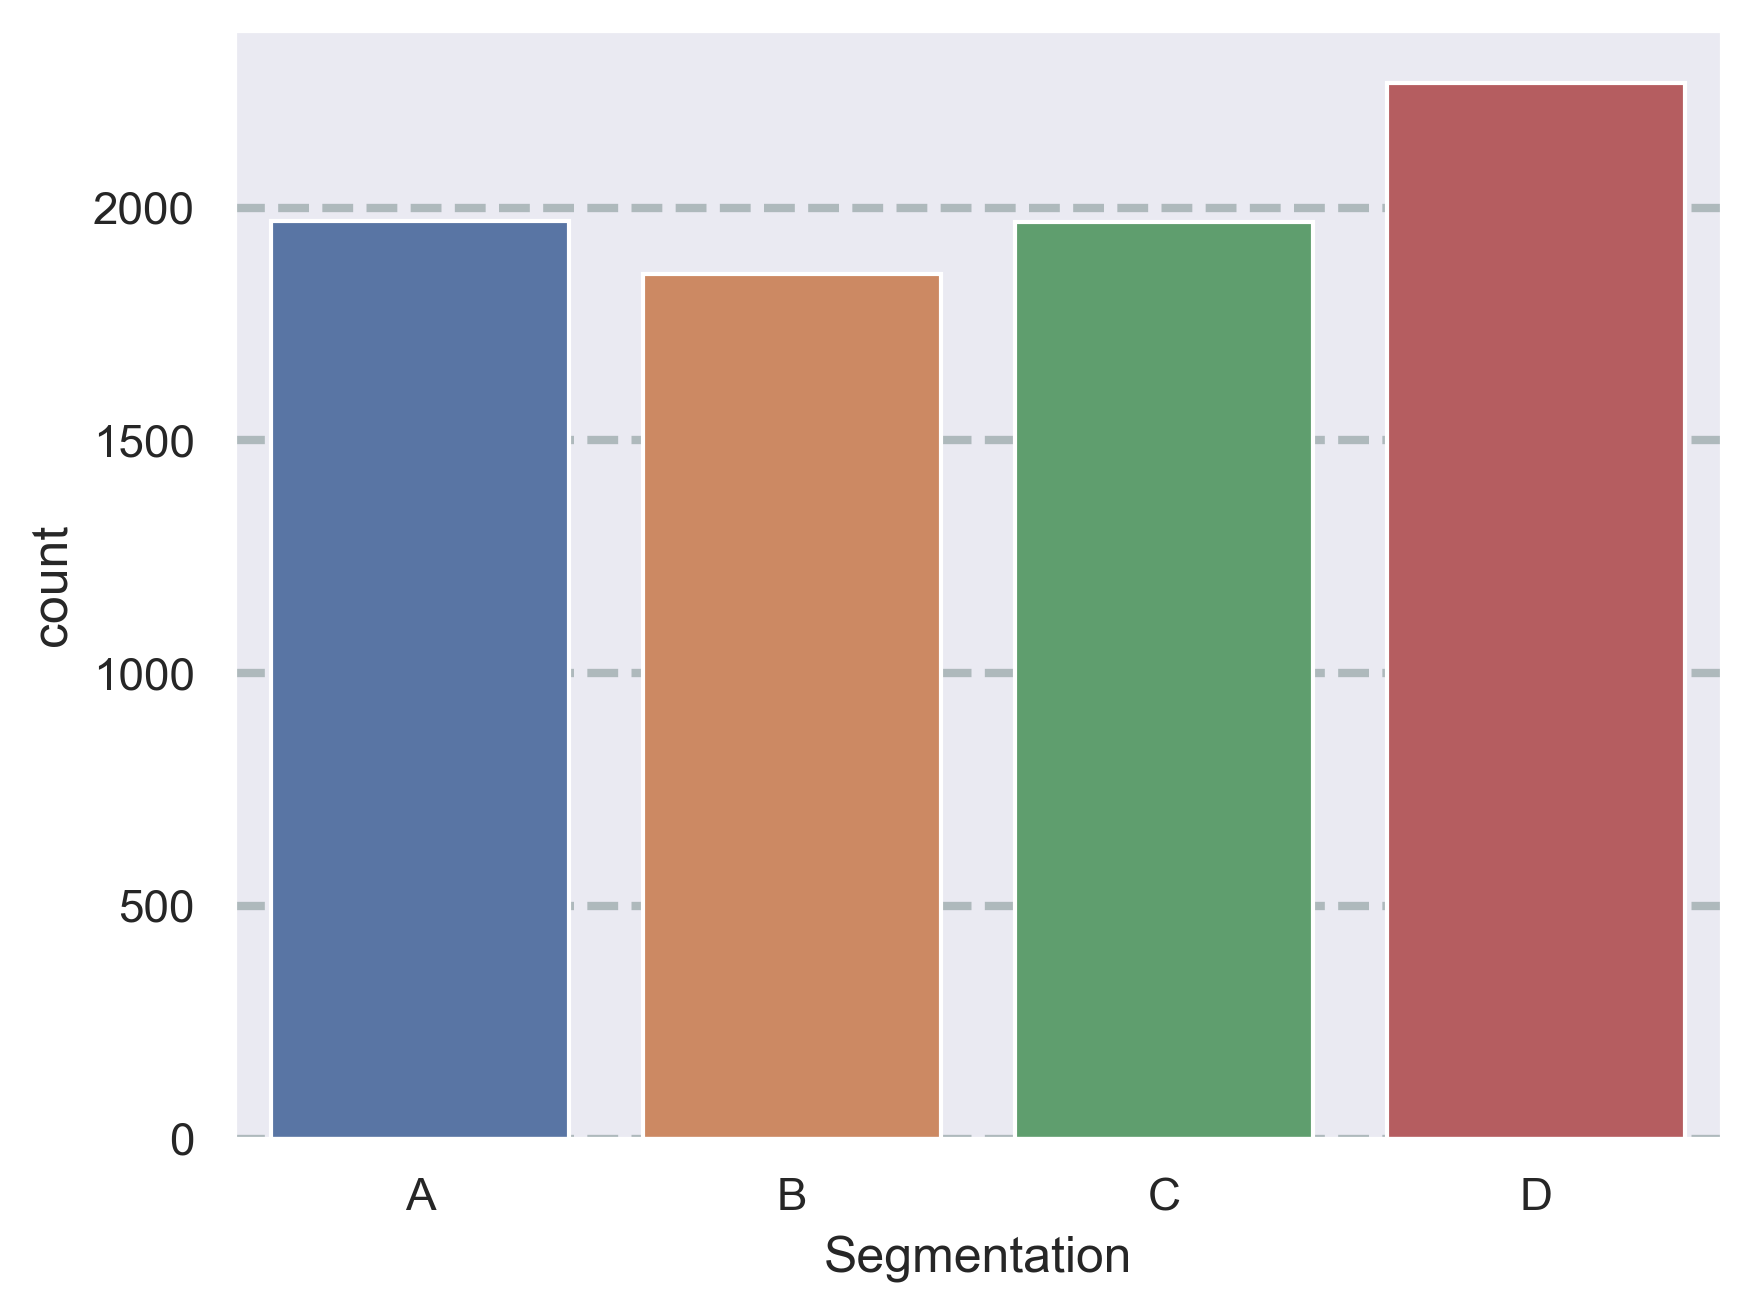

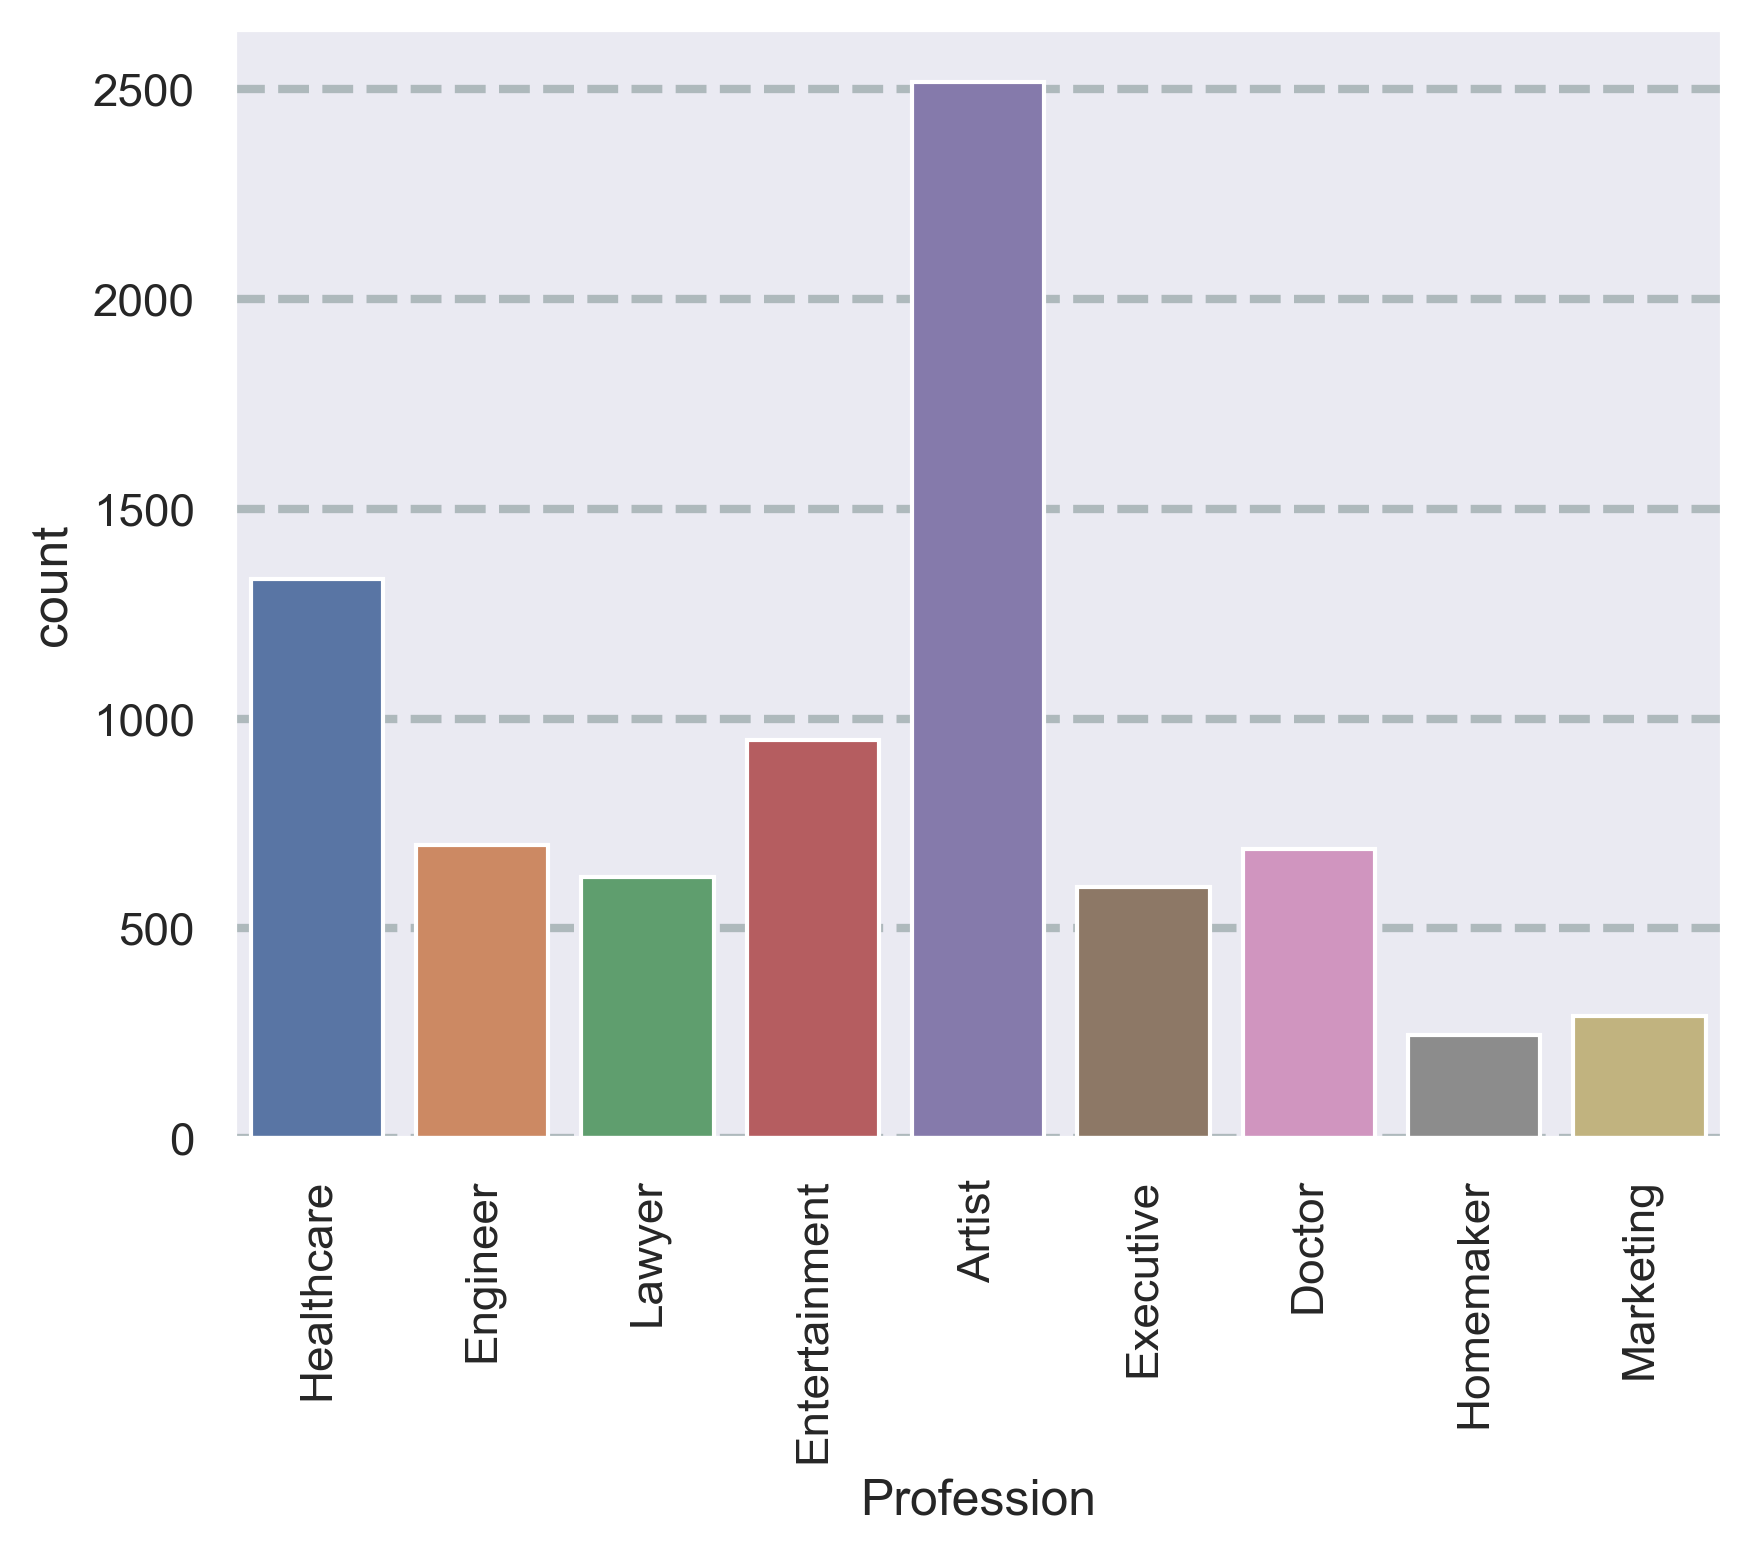

In [8]:
for i, v in enumerate(["Gender", "Ever_Married", "Graduated", "Spending_Score", "Var_1", "Segmentation"]):
    sns.countplot(x = df[v].astype('category'))
    plt.show()
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)

sns.countplot(x="Profession", data=df)
plt.xticks(rotation=90)
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)

Initial look at the categorical data provides some interesting information:
- The number of individuals placed into each segement is very similar
- Majority of individuals tend to have a low spending score
- ....

## Categorical features conversion

In [9]:
#Create new variable called Have_Married_Before where if they have its equivalent to 1 in this new variables and 0 if they haven't
df["Have_Married_Before"] = df.Ever_Married.replace({'Yes':1, "No": 0})
#Create new variable called have married before where if they have its equivalent to 1 in this new variables and 0 if they haven't
df["Have_Graduated"] = df.Graduated.replace({'Yes':1, 'No':0})

In [10]:
#Encoding other categorical variabels through label encoding and one hot encoding
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Have_Married_Before,Have_Graduated
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,0.0,0.0
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A,1.0,1.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,1.0,1.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,1.0,1.0
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A,1.0,1.0


## 2. Visualise Data